In [ ]:
using QuantumOptics
using Statistics
using PyPlot
using Random
using JLD2
using CollectiveSpins

In [2]:
function prepare_theta_state(N_ES)
    return shuffle(vcat(zeros(Int, N_ES), ones(Int, N-N_ES)*pi))
end

""" Renormalize list of spins for independent case. Maps <σz> to go from [-1, 1] to [-1, 2N_ES/N - 1] """
function renorm_spin(list_spins, N_ES, N)
    return (list_spins.+1) .* (N_ES/N) .-1
end

""" Prepare the initial state of the system 
with a phase correlation imposed between the atoms
because the laser arrive on the lattice with an angle θl """
function prepare_phi_IS(θl, λl, theta_array)
    phi_array = zeros(N)
    for i = 1:N
        phi_array[i] = 2pi * sqrt(sum((system.spins[i].position .* [cos(θl), sin(θl), 0]) .^ 2))
    end
    return phi_array
end

prepare_phi_IS

### Define the system

In [10]:
# Define geometry of system
Nx,Ny,Nz = [5,5,1]
N = Nx*Ny*Nz
d_xy, d_z = 266., 532.
λ = 1299.
θl = 30*pi/180

theta_init = pi/2
phi_init = 1

# Integration time
Tstep = 1e-3
Tend = 1#Tstep
T= [0:Tstep:Tend;];

In [11]:
a,b,c = [d_xy,d_xy,d_z]/λ
geo = CollectiveSpins.geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
e = [0,0,1]   # Quantization axis
system = CollectiveSpins.SpinCollection(geo, e, gammas=1.);

### Computations

In [12]:
repetition = 10; # Nbr of repetition per initial excited states

In [ ]:
Mean_σz_array = []
Std_σz_array = []
Diff_mean_σz_array = []
Std_diff_σz_array = []

for N_ES in 1:2:N
    println(string(N_ES)*"/"*string(N))

    σz_rep = []

    for j = 1:repetition
        # Initial state
        Ψ0 = CollectiveSpins.mpc.blochstate(zeros(N), prepare_theta_state(N_ES))
        ρt = CollectiveSpins.mpc.timeevolution(T, system, Ψ0, dt=Tstep)[2]
        push!(σz_rep, [(-1*(mean(CollectiveSpins.mpc.sz(ρ))+1)/2 -6) for ρ in ρt])
    end

    push!(Mean_σz_array, mean(σz_rep))
    push!(Std_σz_array, std(σz_rep))
    push!(Diff_mean_σz_array, -diff(Mean_σz_array[end])./Tstep)
    push!(Std_diff_σz_array, std([-diff(σz)./Tstep for σz in σz_rep]))
end

1/25
3/25
5/25
7/25
9/25
11/25
13/25
15/25


In [ ]:
# Independent case
phi, theta = 0., 0.
Ψ0_ind = CollectiveSpins.independent.blochstate(phi, theta, N)
geo = CollectiveSpins.geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
system = CollectiveSpins.SpinCollection(geo, e, gammas=1.)
tout, ρt_ind = CollectiveSpins.independent.timeevolution(T, system, Ψ0_ind, dt=Tstep)
mean_σz_ind = [mean(CollectiveSpins.independent.sz(ρ)) for ρ in ρt_ind]

Mean_σz_ind_array = []
Diff_mean_σz_ind_array = []

for N_ES in 1:2:N
    push!(Mean_σz_ind_array, (-1 .*(renorm_spin(mean_σz_ind, N_ES, N) .+1) ./2) .-6)
    push!(Diff_mean_σz_ind_array, -diff(Mean_σz_ind_array[end])/Tstep)
end

### Plot CS

In [ ]:
close("all")
figure()
for i = 1:N÷2
    plot(Mean_σz_array[i], label=string(i))
    plot(Mean_σz_ind_array[i], linestyle="--", label=string(i))
end
legend()
gcf()
#pygui(true); show()

# Load QC

In [ ]:
"Solutions/Sol_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_thetal_$(round(θl, digits=2))_NES_$NES

In [9]:
diff_init_QC = []
for NES in 1:2:N
    @load "Solutions/Sol_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_thetal_$(round(θl, digits=2))_NES_$NES" sol
    mean_σz_QC = [2*mean(real(sol[i][1:N]))-1 for i=1:2]
    mean_σz67_QC = -1 .*(mean_σz_QC.+1) ./2 .- 6
    push!(diff_init_QC, diff(mean_σz67_QC)[1]/Tstep)
end

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 /Users/remy/.julia/packages/JLD2/pdSa4/src/JLD2.jl:152


SystemError: SystemError: opening file "Solutions/Sol_QC_Nx_5_Ny_5_Nz_1_theta_1.6_phi_1_thetal_0.52_NES_1": No such file or directory

### Plots

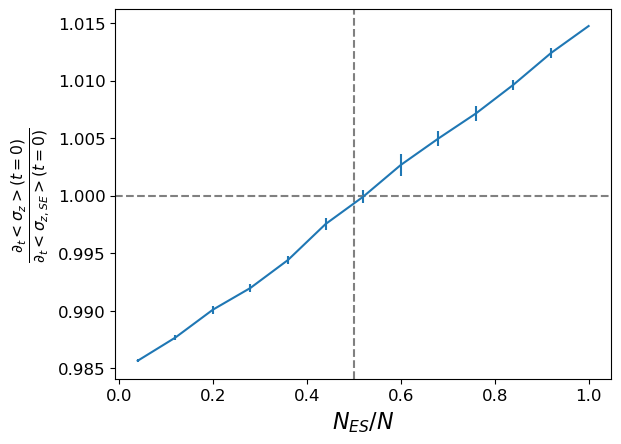

In [114]:
close("all")
figure()

PyPlot.rc("font", size = 12)

errorbar([i/N for i = 1:2:N], [Diff_mean_σz_array[i][1]./Diff_mean_σz_ind_array[i][1] for i=1:length(Diff_mean_σz_array)], yerr=[Std_diff_σz_array[i][1] for i=1:length(Diff_mean_σz_array)])
xlabel(L"N_{ES}/N", fontsize=16)
ylabel(L"\frac{\partial_t<\sigma_z>(t=0)}{\partial_t<\sigma_{z, SE}>(t=0)}", fontsize=16)
axhline(1, linestyle="--", color="gray")
axvline(0.5, linestyle="--", color="gray")
#title(L"Normalised initial slope of $<\sigma_z>$ as a function of "*"\n"*"the number of ES in the initial state")

savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/Initial_slope(NES).pdf", bbox_inches="tight")

pygui(false); gcf()

In [ ]:
# Save data
#= save_object("Mean_sigmaz_var_NES_rep.jld2", Diff_mean_σz_array)
save_object("Std_sigmaz_var_NES_rep.jld2", Std_diff_σz_array) =#

In [7]:
# Load data
Diff_mean_σz_array = load_object("Mean_sigmaz_var_NES_rep.jld2")
Std_diff_σz_array = load_object("Std_sigmaz_var_NES_rep.jld2");